In [6]:
import os
from os.path import isdir, join

from pathlib import Path
import pandas as pd
from data_import import data_import
import time
#loadmat
from scipy.io import loadmat,savemat

# Math
import numpy as np
from scipy.fftpack import fft, dct
from scipy import signal
from scipy.stats import norm,multivariate_normal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

#math
import math

%matplotlib inline

# 1. Import the data

In [10]:
audio_path = "D:\\LAB\\workspace\\lab\\patRecDat\\forStudents\\timit\\test"
#audio_path = "/Users/Mata/Documents/2017/学习/ws2017:18/PUL/forStudents/timit/test"

In [11]:
dataset=data_import(audio_path,0)

In [12]:
data_all=np.concatenate(dataset.get('mrpc0','no such file'))
data_all_test=np.concatenate(dataset.get('fnmr0','no such file'))

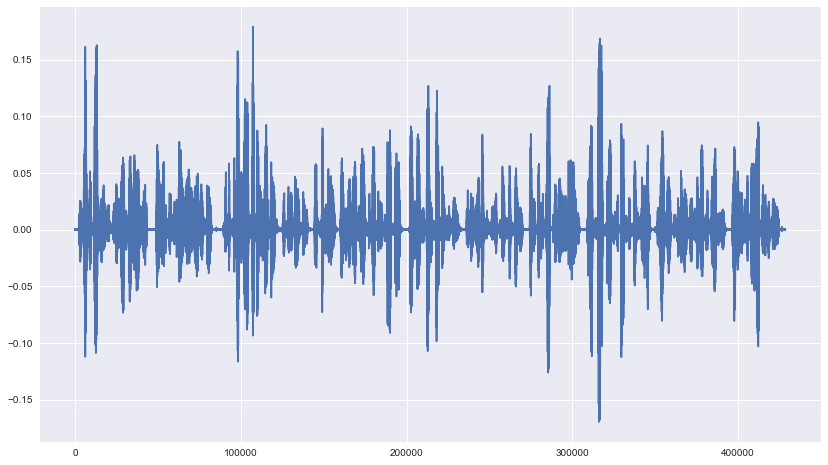

In [25]:
plt.figure(figsize=(14,8))
plt.plot(np.linspace(0,len(data_all),len(data_all)),data_all) 
#np.linspace(): set up 3rd argument to sample_rate,otherwise default=50
plt.show()

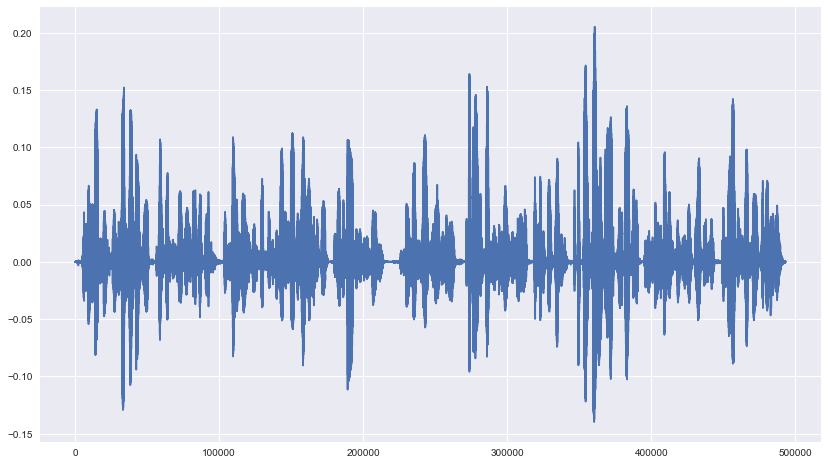

In [26]:
plt.figure(figsize=(14,8))
plt.plot(np.linspace(0,len(data_all_test),len(data_all_test)),data_all_test) 
#np.linspace(): set up 3rd argument to sample_rate,otherwise default=50
plt.show()

# 2. Frame segmentation

In [18]:
sample_rate=16000
t_feed=10 #feed time
t_frame=20 #frame time
fs=sample_rate/1000 #sample_rate of each ms
L_value=np.int(fs*t_frame)
L_value

320

In [20]:
def frame_segment(samples):
    #frame_num = K 
    frame_num=np.int((len(samples)-L_value)/(fs*t_feed))+1 #calculate the number of frames
    frame_set=[]
    for k in range(frame_num):
        frame_set.append(samples[k*np.int(fs*t_feed):k*np.int(fs*t_feed)+L_value])#[0,n] contains 0~n-1
    return frame_set,frame_num

In [27]:
#separately applying frames segmentation to the wav files
frame_set,frame_num=frame_segment(data_all)

In [35]:
frame_set=np.array(frame_set)

In [16]:
for item in frame_set:
    print(item.shape)

(354, 320)
(265, 320)
(281, 320)
(342, 320)
(253, 320)
(289, 320)
(213, 320)
(212, 320)
(237, 320)
(216, 320)


In [17]:
def get_noise_signal(frame_set,t_n=100):
    #step 1
    mixed_power_all_set=[]
    for item in frame_set:
        mixed_power_set=[]
        for k in range(len(item)):
            #use np.float64 to avoid overflow encountered in long scalars
            mixed_power_set.append(1/(L_value)*np.sum((np.float64(item[k]))**2))
        mixed_power_all_set.append(np.array(mixed_power_set))
    #step 2
    noise_power_set=[]
    frame_drop=np.int((t_n/t_feed)-1)
    for item in mixed_power_all_set:
        no_speech_set=item[:frame_drop]
        noise_power_set.append((1/frame_drop)*np.sum(no_speech_set))
    return mixed_power_all_set, noise_power_set
    

In [41]:
mixed_power_set,noise_power_set=get_noise_signal(frame_set)
mixed_power_set_test,noise_power_set_test=get_noise_signal(frame_set_test)

In [19]:
np.concatenate(mixed_power_set)

array([  8.43125 ,   7.70625 ,   2.284375, ...,  28.884375,  18.1125  ,
        14.79375 ])

In [20]:
noise_power_set

[12.493749999999999,
 23.555902777777778,
 439.32395833333339,
 3.2361111111111112,
 6.1677083333333336,
 12.244791666666668,
 3.7072916666666664,
 2.5704861111111112,
 11.514930555555555,
 5.9704861111111107]

try to plot the noise frames and voice frames according to different $\gamma$

In [25]:
def noise_plot_all(mixed_power_set,noise_power_set,frame_num,gamma=500):
    print("plot start")
    selected_power_all_set=[]
    for index in range(len(mixed_power_set)):
        selected_power_set=mixed_power_set[index].copy()
        selected_power_set[selected_power_set<gamma*noise_power_set[index]]=0
        selected_power_all_set.append(selected_power_set)
    #print("the selected_power_set shape is ",np.concatenate(selected_power_all_set).shape)
    
    plt.figure(figsize=(14,8))
    plt.bar(range(frame_num),np.concatenate(mixed_power_set),color='red')#plt,bar(index,height(value))
    plt.bar(range(frame_num),np.concatenate(selected_power_all_set))
    #plt.hlines( gamma*noise_power_set, 0, frame_num,label ="$\gamma$ %5.1f"%(gamma), linestyles = "dashed" )
    
    #plt.legend()
    plt.ylabel("amplitude",fontsize=20)
    plt.xlabel("frame_num",fontsize=20)
    plt.title( 'step 3 at different $\gamma$ %5.1f'%(gamma),fontsize=25 )
    plt.show()

plot start


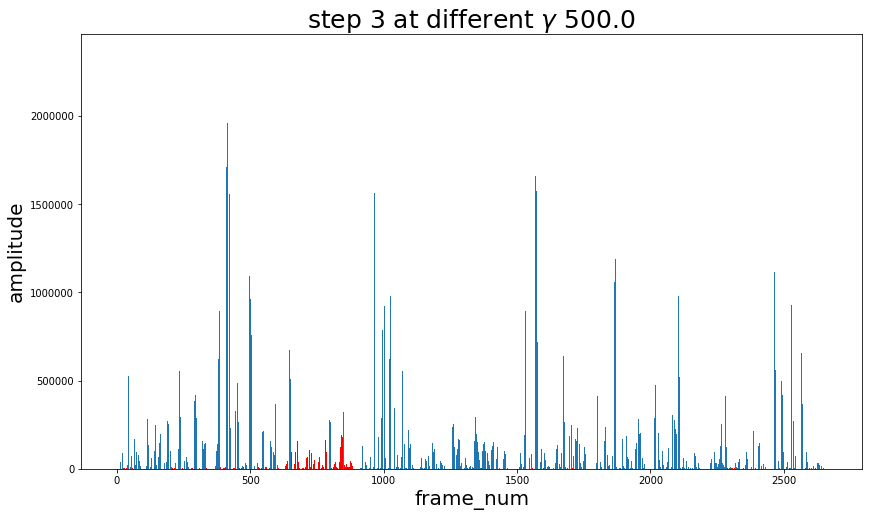

In [26]:
noise_plot_all(mixed_power_set,noise_power_set,frame_num)

In [22]:
#ipd.Audio("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\timit\\test\\dr7\\mrpc0\\sx313.wav")
ipd.Audio("/Users/Mata/Documents/2017/学习/ws2017:18/PUL/forStudents/timit/test/dr7/mrpc0/sx313.wav")
#audio_path = "/Users/Mata/Documents/2017/学习/ws2017:18/PUL/forStudents/timit/test"

plot start


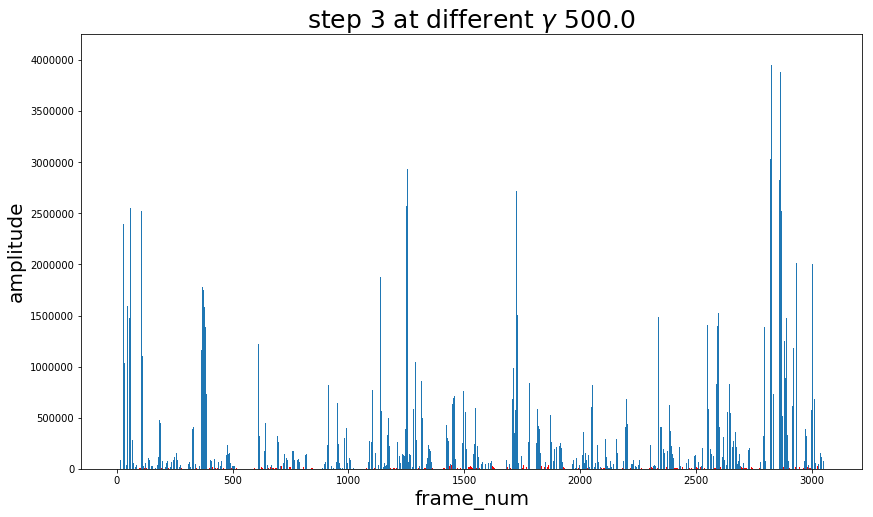

In [42]:
noise_plot_all(mixed_power_set_test,noise_power_set_test,frame_num_test)